TODO: Introducir el método de RandomForest

In [46]:
import matplotlib.pyplot
import numpy
import pandas
import random
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import sklearn.tree

A continuación cargamos el conjunto de datos discretizado.

In [26]:
# Definicion de funcion para discretizar variables por cuantiles
def DiscretizarPorCuantiles(datos, columnas, intervalos):
    datosNuevos = datos.copy()
    informacion = {}
    for columna in columnas:
        paso      = 1 / intervalos
        cuantiles = numpy.arange(0, 1.0 + paso, paso)
        etiquetas = list(map(str, numpy.arange(1, intervalos + 1)))

        (nuevosDatos, intervalosEtiquetas) = pandas.qcut(x=datos[columna], q=cuantiles, labels=etiquetas, retbins=True)
        datosNuevos[columna] = nuevosDatos
        informacion[columna] = { "cuantiles": cuantiles, "etiquetas": etiquetas, "intervalos": intervalosEtiquetas }
    return [datosNuevos, informacion ]

# Lectura de set de datos discretizado
setDatosOriginal = pandas.read_csv(filepath_or_buffer = "input/SetDatosDiscretizado.csv", sep = "\t",
                                       na_values = "NA")
setDatosDiscretizado, informacion = DiscretizarPorCuantiles(datos=setDatosOriginal, columnas=['age','height','weight'], intervalos=10)

# Separo los features del data frame del target a aprender
atributos = setDatosDiscretizado.drop(columns = [ "id", "cardio" ])
objetivo  = setDatosDiscretizado['cardio']


Luego, separamos el conjunto de datos en conjunto de *desarrollo* y conjunto de *test*

In [27]:
# Separar en sets de desarrollo (entrenamiento + validacion) y testeo
atributosDesarrollo, atributosTest, objetivoDesarrollo, objetivoTest = \
    sklearn.model_selection.train_test_split(atributos, objetivo, train_size = 0.8, test_size = 0.2, random_state = 0)

# Separar el set de desarrollo en sets de entrenamiento y validacion
atributosEntrenamiento, atributosValidacion, objetivoEntrenamiento, objetivoValidacion = \
    sklearn.model_selection.train_test_split(atributosDesarrollo, objetivoDesarrollo,
                                             train_size = 0.8, test_size = 0.2, random_state = 0)

Ahora definimos el clasificador *RandomForestClassifier* y realizamos predicciones para distinta cantidad de estimadores

In [55]:
clasificadorRandomForest = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, criterion="gini", max_depth=6, random_state=0)
clasificadorRandomForest.fit(atributosDesarrollo, objetivoDesarrollo)  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Ahora calculamos métricas utilizando el conjunto de test

In [29]:
predicciones = clasificadorRandomForest.predict(atributosTest)
accuracy     = sklearn.metrics.accuracy_score(objetivoTest, predicciones)
accuracy
print(clasificadorRandomForest.feature_importances_)

[0.1048678  0.00101137 0.0029251  0.03021486 0.51603509 0.23300795
 0.09614268 0.00891515 0.00223833 0.0012923  0.00334936]


Finalmente, graficamos la importancia de cada uno de los atributos a los efectos del ajuste según los resultados devueltos por el clasificador *Random Forest*.

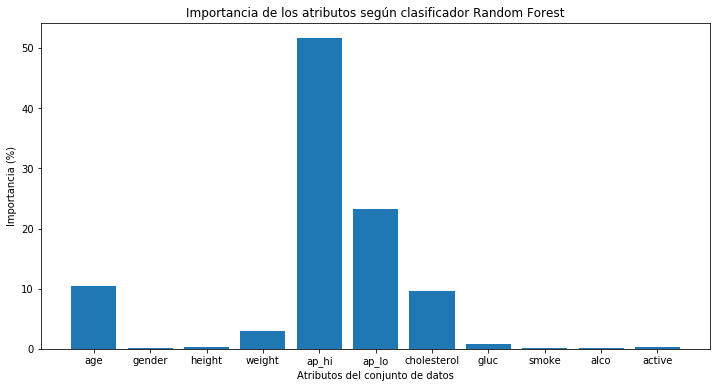

In [54]:
valoresX      = atributosDesarrollo.columns
valoresY      = 100 * clasificadorRandomForest.feature_importances_
figura, panel = matplotlib.pyplot.subplots(figsize = (12, 6))
panel.bar(valoresX, valoresY)
panel.set_xlabel('Atributos del conjunto de datos')
panel.set_ylabel('Importancia (%)')
panel.set_title('Importancia de los atributos según clasificador Random Forest')
figura.show()